## Docler Holding take home assignment
Classification task - 3rd June 2020

This report concludes my results and findings about the problems in take home assignment. The problems are the following: 
- use the cifar-10 dataset and a selected CNN model to classify the data (only use 1000 images for traning)
- modify the network to produce 2 outputs
- optimize the neural network and evaluate metrics


This notebook only presents the result. The code base " modified_mobilenet_1k_baseline.py " can found at project's the directory. The libraries I used are: `Pytorch`, `numpy`, `matplotlib`.



### 0. Understanding the data
The cifar-10 dataset consists of 60000 images of 10 classes. These classes are: plane, car, bird, cat,
deer, dog, frog, horse, ship, truck. The dataset is balanced, each class consists of 6000 images. The images were downloaded from: https://www.cs.toronto.edu/~kriz/cifar.html. The data can be found under the directory "/data". This contains 6 pickled data files: data_batch_1-5, and test_batch. Originally the data_batches were used for traning, but we will only use a smaller subset of the data to train the network.

In [1]:
import modified_mobilenet_1k_baseline as base #import scripts I wrote
import torch.nn as nn
import torch.optim as optim
import torch as torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

First, let's unpickle the data, extract images and labels. The we have to reshape the images as they were stored as row vectors of size 1x1024. We will reshape them to size 32x32.

In [2]:
#unpickle the data , extract images and labels
#get data to shape of 32x32
PATH = "data"
data, labels = base.load_all(PATH)
data = base.get_shape_32x32(data)
print(data.shape) 

(60000, 3, 32, 32)


Now we have a dataset that consisting of 60000 images, 3 color channels and 32x32 size. We can see at the following cell that we have indeed a balanced dataset, each class consists of 6000 images.

Counter({6: 6000, 9: 6000, 4: 6000, 1: 6000, 2: 6000, 7: 6000, 8: 6000, 3: 6000, 5: 6000, 0: 6000})
2


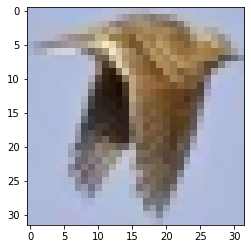

In [3]:
print(Counter(labels))

#showing one data point
example = data[123]/255
example = torch.Tensor(example)
plt.imshow(example.permute(1, 2, 0))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(labels[123]) #returns 2, classes[2] == bird

### 1. Prepare the data

The task was to select 1000 images from this dataset. For this, I selected 100 images from each class. The reason I did this is I assumed that the data is i.i.d. and I can randomly sample from it, and I wanted to train the network on a balanced dataset. 
I calculated an index set which contains the indeces for traning.

In [4]:
#calcualte index set: will use to split dataset
#we will randomly sample 100 images from each class to have a balanced dataset
indeces = base.get_100_from_each(labels)

Method used: create an empty list where we will store the labels.
From each class select 100 occurences with np.random.choice(all_class_id,size=100,replace=False)

#### Preprocessing
Next, I divided each data point to have values between 0-1, than calcualted the mean and standard deviation for the dataset, to normalize each data point. I also splitted the dataset into train-test data and labels. The following function `base.normalize_split()` does these steps. Note that at this point I did not use any other data transformation than normalization.

In [5]:
#normalize each data point, split data to two PyTorch datasets 
train_data, train_labels, test_data, test_labels = base.normalize_split(indeces, data, labels)
print(Counter(train_labels))

Counter({9: 100, 5: 100, 6: 100, 4: 100, 1: 100, 2: 100, 3: 100, 8: 100, 0: 100, 7: 100})


Next, I created a dataset and `dataLoader` PyTorch objects. These will store the data tensors and the labels. 

In [6]:
#create PyTorch datasets with batch size 32
train_dataloader, test_dataloader = base.create_dataset(train_data, test_data, train_labels, test_labels, 32)

### 2. Selecting a model and modifying the model
The model I selected to train on this dataset is the MobileNetV2. The reason I choose this model is that it achieves similar results than deeper convolutional models, but it has much less parameters to learn. This network is ideal for low resource devices (such as mobiles). This network only has ~4.2M parameters while, for example, ResNet-101 has ~58M.

MobileV2Net uses an inverted residual structure, and it has depthwise and pointwise convolutional layers. (https://arxiv.org/abs/1801.04381)

I also had to modify the network to have a second output that always produces ones.
To do the following, I rewrote the forward function of the code to be:
`def forward(self, x):
     x = self.features(x)
     x = x.mean([2, 3])
     x1 = self.classifier(x)
     x2 = torch.ones((x.shape))
     return x1, x2`

This will return two outputs, x1 being the original output of the network and x2 being a dummy tensor of the same shape as x1. This dummy only contains 1-s. 

To my best understanding, I did not have to train the model on both of these outputs, only on the original output. If I have to train on both the outputs, I would rewrite the following in the training:

` for i, data in enumerate(train_dataloader, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs, outputs2 = net(inputs)
    loss1 = criterion(outputs, labels)
    loss2 = criterion(outputs2, labels) 
    loss= loss1 + loss2
    loss.backward()
    optimizer.step()`

Next let's initialise the model with Cross-entropy loss and RMSprop optimizer.
Cross-entropy loss is often used in multi label classificatin and it increases as the predicted probability diverges from the actual label. RMSprop is an adaptive optimizer that uses a moving average of squared gradients to 'normalise' the weights.

In [7]:
net = base.mobilenet_v2(pretrained=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=4e-5)

I trained this model in Colab "modified_mobilenet_train.ipynb" and saved the model parameters. The Colab notebook can be also found in the project's folder. Let's load in the model parameters and make some predictions.

In [8]:
saved_model = 'modified_model_1k_2'
checkpoint = torch.load(saved_model,map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
criterion = checkpoint['loss']

#### Regularization
I used weight decay (L2 Regularization) in the optimizer and batch normalization in the network to optimize the network.

### 3. Evaluate the model
I will plot a graph that was made during traning to show the loss. This is to avoid overfitting.

I will also show the accuracy of the prediction for the whole dataset and for each classes.

Losses during traning (trained for 10 epochs):
<img src="losses.png">

In [9]:
#evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data

        outputs,outputs2 = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 59000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 59000 test images: 31 %


Achieved accuracy on the test set is 31% which is really low, but the same model with the same parameters achieved 68%, using 50k images to train and 10k images to test. I conclude that this is not a horrible accuracy given that we only use 1k images to train.

In [10]:
#demonstrate that the model produces the actual output and the dummy output:
for data in test_dataloader:
        images, labels = data
        outputs, outputs2 = net(images)
        _, predicted = torch.max(outputs.data, 1)
        print(outputs[0])
        print(outputs2[0])
        break

tensor([-1.4897, -5.4772,  3.1550,  3.6973,  2.1079,  3.7830,  1.3772,  0.6955,
        -2.1807, -3.3048], grad_fn=<SelectBackward>)
tensor([1., 1., 1.,  ..., 1., 1., 1.])


Now let's see how many of the missclassification error concentrates in some classes. For this we will show the accuracy predicted for each class.

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data

        outputs,outputs2 = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [12]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 56 %
Accuracy of   car : 43 %
Accuracy of  bird : 28 %
Accuracy of   cat : 10 %
Accuracy of  deer :  6 %
Accuracy of   dog : 37 %
Accuracy of  frog : 44 %
Accuracy of horse : 39 %
Accuracy of  ship : 21 %
Accuracy of truck : 32 %


We can see that for example labels truck and cat has low accuracy. 

### 4. Next steps
If I had more time, I would do the followings:
1. Data augmentation - usually improves accuracy and helps avoiding overfitting. This would include randomCrop and flipping the images.
2. Selecting a different subset of images. We can see that some classes perform well like plane or frog, while other classes such as cat or deer have really low accuracy. We can try to manually increase the traning examples for the low accuracy classes and decrease for higher accuracy classes. We can also take a look at the confusion matrix to see the correlation between the missclassified images.
3. Transfer learning - using knowlegde from a different dataset
4. Hyper-parameter tuning. This includes: epochs, batch size, optimizer parameters.

5. To deploy the model I would use Flask API